# Detecting hidden but non-trivial problems in transfer learning models using Amazon SageMaker Debugger

This notebook contains the notebook and training scripts for the blogpost **Detecting hidden but non-trivial problems in transfer learning models using Amazon SageMaker Debugger**

In this notebok, we’ll show you an end-to-end example of doing transfer learning and using SageMaker Debugger to detect hidden problems that can cause serious consequences that would not have been easily uncovered. Debugger does not incur additional cost if you are running training on Sagemaker. Moreover, you can enable the [built-in rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html) with just a couple lines of code when you call the Sagemaker estimator function. Our task is to do transfer learning using a ResNet Model to recognize [German traffic sign dataset](https://ieeexplore.ieee.org/document/6033395).


### Table of Contents

##### Create training 
1. [Download the data](#download)
2. [Define the training script](#training-script)

##### Setup SageMaker training with Debugger
3. [Debugger built-in rules](#rules)
4. [Select and configure rules](#select-rules)
5. [Debugger hook configuration](#debugger-hook)
6. [Run SageMaker training](#sagemaker-training)

##### Investigate why rules triggered and inspect model with Debugger
7. [Check rule status](#rule-status)
8. [Read Debugger data](#read-debugger-data)
9. [Investigate why 'Loss not decreasing' rule trigger](#loss)  
10. [Enable auto-termination when rule triggered](#termination)
11. [Investigate why 'Class imbalance' rule triggered](#classimbalance)
12. [Plot confusion matrix](#confusion)
13. [Inspect incorrect predictions](#incorrect)

##### Fix the training script and re-run the training
14. [Custom rule](#custom)
15. [Fix and re-run the training](#fix)

### Download the data <a name="download"></a>


Before we get started, let's first download the training and testdatset.


In [ ]:
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
! unzip -q GTSRB-Training_fixed.zip

In [ ]:
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
! unzip -q GTSRB_Final_Test_Images.zip

In [ ]:
! wget https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv

Next we download label names, which is a csv file that contains the names for each image class.

In [8]:
from pandas.io.parsers import read_csv
signnames = read_csv("signnames.csv").values[:, 1]

We have to re-arrange the test data so that we have a separate subfolder for each image class. The file `GTSRB_Final_Test_GT.zip` contains a csv that shows which test image belongs to which class.

In [ ]:
! wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
! unzip -q GTSRB_Final_Test_GT.zip

In [9]:
import csv
import os
import shutil

if not os.path.isdir('GTSRB/GTSRB_Test'):
    os.mkdir('GTSRB/GTSRB_Test')

with open('GT-final_test.csv') as file:
    reader = csv.reader(file,delimiter=";")
    next(reader)
    for line in reader:
        image = line[0]
        classID = line[-1]
        folder = 'GTSRB/GTSRB_Test/'+ "%05d" %int(classID)
        if not os.path.isdir(folder):
            os.mkdir(folder)
        shutil.copy('GTSRB/Final_Test/Images/'+image, folder)

### Define the traning script <a name="training-script"></a>

#### Apply pre-processing

First let’s apply some typical pre-processing for a ResNet model on our dataset (please see the complete notebook for where to download the dataset). To improve model generalization, we apply data augmentation e.g. `RandomResizedCrop` and `RandomHorizontalFlip`. These operations ensure that an image will look differently in each epoch. Lastly we normalize the data: since the model has been pre-trained on the ImageNet dataset, we apply the same preprocessing and normalization e.g. subtract the mean and divide by the standard deviation of the ImageNet dataset. 

In [14]:
from torchvision import datasets, models, transforms

# Define pre-processing
train_transform =  transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

We use Pytorch’s `ImageFolder` function that takes a local folder: it loads all images located in the sub-directories and encodes the directory name as label. Next  we specify the dataloader which takes the batch size and dataset. The dataloader is used during training to provide new batches in each iteration.

In [16]:
import torch

# Apply the pre-processing to the training dataset
dataset = datasets.ImageFolder(root='GTSRB/Training', transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

For validation dataset, we don’t apply data augmentation and only resize images to the appropriate size. 

In [25]:

# Apply the pre-processing to validation dataset
val_transform = transforms.Compose([
                                        transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])

dataset_test = datasets.ImageFolder(root='GTSRB/Final_Test', transform=val_transform)
val_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=64, shuffle=False)

Let's have a look on some of the training images. Since we applied data augmentation and normalization, the image does not look like the original one anylonger:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


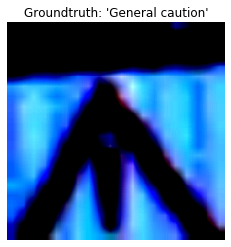

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


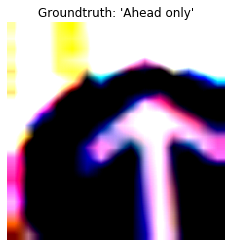

In [28]:
import matplotlib.pyplot as plt
import numpy as np

for index, (image_batch, label) in enumerate(train_dataloader):
    
    image = image_batch[0,:,:,:]
    plt.axis('off')
    plt.title(f"Groundtruth: '{signnames[label[0]]}'")
    plt.imshow(image.permute(1,2,0))
    plt.show()
    if index == 1:
        break

Let's have a look on the validation data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


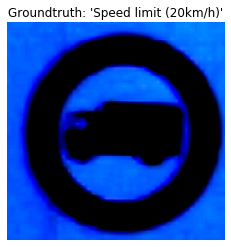

In [34]:
import matplotlib.pyplot as plt
import numpy as np

for index, (image_batch, label) in enumerate(val_dataloader):
    
    image = image_batch[0,:,:,:]
    plt.axis('off')
    plt.title(f"Groundtruth: '{signnames[label[0]]}'")
    plt.imshow(image.permute(1,2,0))
    plt.show()
    if index == 0:
        break

#### Load a pre-trained ResNet model 
Since there are limited variety of traffic signs, we’ll just pick a simpler resnet model for this task.  You can load a ResNet18 from PyTorch model zoo with pre-trained weights using just one line of code.


In [35]:
#get pretrained ResNet model
model = models.resnet18(pretrained=True)

The model has been pre-trained on the ImageNet dataset which consists of 1000 image classes. In our case we fine-tune it on a dataset that only has 43 classes. So we adjust the last layer which is a fully connected Linear layer: 

In [36]:
import torch

#traffic sign dataset has 43 classes
nfeatures = model.fc.in_features
model.fc = torch.nn.Linear(nfeatures, 43)

Since we train a  multi-classification model we use the [cross entropy loss function](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):


In [37]:
#loss for multi label classification
loss_function = torch.nn.CrossEntropyLoss()

Next we specify the optimizer that takes the model parameters and learning rate. Here we use the stochastic gradient descent optimizer:

In [38]:
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#### Define training loop
The following code blocks defines the training loop. We iterate over 5 epochs, perform the forward and backward pass and update the model  parameters.


In [ ]:
for epoch in range(1):  # loop over the entire dataset 10 times
    
    epoch_loss = 0
    
    #iterate over train dataloader
    for index, data in enumerate(train_dataloader):
    
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward 
        outputs = model(inputs)
        
        #compute loss
        loss = loss_function(outputs, labels)
        
        #backward pass
        loss.backward()
        
        #optimize 
        optimizer.step()
        
        #get predictions
        _, preds = torch.max(outputs, 1)

        # statistics
        epoch_loss += loss.item() 
        if index == 3:
            break
    print('Epoch {}/{} Loss: {:.4f}'.format(epoch, 1, epoch_loss)) 

If you just run the code above, the training will be running just on your SageMaker notebook. To make the most out of SageMaker, you want to use SageMaker’s pre-built DLC containers, which come with optimized performance and let you access the full feature sets of Debugger at no additional cost. By running on Amazon SageMaker we can easily train our models at scale. Most deep learning models are trained on GPU due to the computational intensity. By using SageMaker, GPU instances are automatically created and teared down after training completed, so you only pay for the time the resources were used. 

#### Make training script SageMaker compatible

In order to run training on SageMaker, you need to change the location variable in your pre-processing code in to the generic SageMaker environment variables. When SageMaker spins up the training instance it will automatically download the training and validation data from Amazon S3 into a local folder on the training instance. Via `os.environ['SM_CHANNEL_TRAIN']` and `os.environ['SM_CHANNEL_TEST']` we can retrieve the local path.


```python
# update environment variable for training and testing data sets
dataset = datasets.ImageFolder(os.environ['SM_CHANNEL_TRAIN'], transform=train_transform)
dataset_test = datasets.ImageFolder(os.environ['SM_CHANNEL_TEST'], transform=val_transform)
```

After the change, you should save all the code as a separate script. 
Check out the [training script](entry_point/train.py):


In [ ]:
! cat entry_point/train.py

#### Upload data to S3 bucket
As mentioned in the previous step SageMaker will automatically download training and validation data into the training instance. To do so, we need to upload  the data to Amazon S3 first. You can specify the following code in your notebook, that will iterate over all files under GTSRB  folder and uploads the folders and files to S3.


In [45]:
import boto3
import sagemaker
import os

def upload_to_s3(path, directory_name, bucket, counter=-1):
    
    print("Upload files from" + path + " to " + bucket)
    client = boto3.client('s3')
    
    for path, subdirs, files in os.walk(path):
        path = path.replace("\\","/")
        print(path)
        for file in files[0:counter]:
            client.upload_file(os.path.join(path, file), bucket, directory_name+'/'+path.split("/")[-1]+'/'+file)
            
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)
bucket = sagemaker_session.default_bucket()

upload_to_s3("GTSRB/Training", directory_name="gtsrb_train",  bucket=bucket)
upload_to_s3("GTSRB/GTSRB_Test", directory_name="gtsrb_test", bucket=bucket)


<br/>

### Debugger built-in rules <a name="rules"></a>

Now that we have defined the training script and uploaded the data, we are ready to start training on SageMaker. We run the training with several Debugger [builtin rules](https://docs.aws.amazon.com/sagemaker/latest/dg/use-debugger-built-in-rules.html) enabled. Via the SageMaker Python SDK and the rule_configs module, we can select any of the 20 available builtin rules which can be run at no additional cost. Uncomment the following line of code and press tab. The code auto-completion will show you the list of available rules.

In [39]:
from sagemaker.debugger import Rule, CollectionConfig, rule_configs

#rule_configs.

<br/>

Check out this section, if you want to learn more in-depth details about Debugger and its built-in rules. Otherwise feel free jump to section [Select and configure rules](#select-rules).

The following list ist just a brief overview of some of the available builtin rules that could be relavant for our model. For a detailed description for each of them check out the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/use-debugger-built-in-rules.html). Since Debugger can capture any tensor of a model, one can check for issues related to data, model, layer configurations, optimizer settings, etc.

#### Datasets:

Real world data-sets are typically imbalanced and noisy. If the model training does not account for those factors, it will lead to a model that has low or no predictive power for the classes with few samples. There are different ways this problem can be addressed: for instance during data-loading more samples can be drawn from the under-represented classes or one can adjust the loss function to assign a higher penalty to incorrect predictions using class weights. Debugger provides a built-in rule [class-imbalance](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#class-imbalance) that analyzes the model inputs and predictions. 
Since Debugger has access to the inputs after data-loading, the rule can determine if preprocessed data has been re-sampled or not. The rule triggers if the imbalance ratio is above a pre-defined threshold.

Further Debugger provides a rule [check-input-images](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#checkinput-mages) to verify if data has been correctly normalized checking for zero mean and unit variance. In case of NLP models Debugger provides the rule [nlp-sequence-ratio](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#nlp-sequence-ratio) that checks the ratio of specific tokens given the rest of the input sequence which is useful for optimizing performance. 

<br/>

#### Gradients:

Deep neural networks consists of many layers and quite commonly gradients may vanish the more layers a network has. This prevents deeper layers  learning because they only receive small gradients.
For instance the following animation shows that the gradients are in the order of 10^-7 and decrease further as training is progressing. If this happens from the beginning of the training, then the model does not learn.

<img src="images/gradients.gif" alt="drawing" width="300"/>


Residual connections or BatchNorm layers can mitigate this problem. Vanishing gradients can also be caused by activation functions such as sigmoid and tanh that saturate more quickly. Choosing instead an activation function like LeakyReLu can stabilize the training. Vanishing gradients is especially a problem in recurrent neural networks, where they can prevent the network from developing a long-term memory. Contrarily gradients may also explode and gradient clipping can help to stabilize the training  In both cases, continuing training when the model has too small or large gradients, would not be useful. Debugger provides a built-in rule [vanishing-gradient](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#vanishing-gradient) and [exploding-tensor](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#exploding-tensor) to determine the statistical properties of the gradients such as min, max, mean and raises an alarm if a predefined threshold is exceeded.



<br/>

#### Weights:
Initialization assigns random values to parameters. If all parameters have the same initial value, they receive the same gradient and as a consequence the model would not be able to learn. If parameters are initialized with too small or large values, it may lead to vanishing or exploding gradients and neuron saturation. The goal of initialization is to break the symmetry such that weights connected to the same neuron do not have the same values and can learn independently. 
Debugger has a built-in rule [poor-weight-initialization](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#poor-weight-initialization) that runs at the start of model training and verifies if weights have been well intialized. A bad intialization prevents convergence, so stopping the training is advised and can be automated with Debugger saving users time and costs. Debugger also provides a built-in rule [weight-update-ratio](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#weight-update-ratio) that measures by how much weights changed between consecutive steps. If weights are small and its updates neglible throughout the whole training it may indicate that weights can be pruned.

<br/>

#### Activation functions:

Deep neural networks consist of activation functions that determine the output of a node given a set of inputs. This allows the network to learn non-linear mappings and without such non-linear transformations the network would not be able to perform any complex tasks. Depending on the type of activation, neurons may suffer from saturation which means that a neuron outputs values close to the asymptotic bounds of the function. This results in vanishing gradients leading to insignificant parameter updates and preventing the model from learning. This is a well known problem for tanh and sigmoid (see left image below): activation functions that have been commonly used in the early days of deep learning and may prevent the training of complex models to converge. Debugger provides the builtin rule [saturated-activation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#saturated-activation) that counts the number of saturated neurons and raises an alarm if the number is above a pre-defined threshold.

<img src="images/activation_functions.png" alt="drawing" width="800"/>


Many state of the art models use ReLU activation which is a non-linear rectified unit: a function that is linearly increasing for increasing positive values and outputs zero otherwise (see right image above). A model can suffer from the dying ReLU problem, where the gradients become zero due to the activation output being zero. If too many neurons suffer from this problem, then the model can't effectively learn. Debugger has a built-in rule [dead-relu](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#dead-relu) that measures the number of dead ReLUs in a model and if a pre-defined threshold is exceeded, an issue is raised.

The root causes of neuron saturation and dead ReLUs can be mitigated by scaling the input data to have zero mean and unit variance. This symmetric initialization avoids a dead ReLU problem. Additionally, avoiding weights growing too large which could push activation functions to their asymptotic bounds. ReLU is an unbounded function and adding a penalty term on large activation values helps to keep activations small and sparse. 
Activation functions such as LeakyReLU, Elu, Selu etc. are non linear functions that allow small negative outputs and circumvent the dying ReLU problem.  



<br/>

#### Loss and accurcay:
If the model training is incorrectly configured then this almost always leads to the problem that the loss during training won’t converge. Multiple possible scenarios can occur such as training loss decreases in contrast to the validation loss. This is a clear indication of over-fitting, a model that works well on the data it has seen during training, but that can not generalize to unseen data. If neither training nor validation loss decrease then the model is under-fitting the data and misses relevant relations between features and outputs.
If training and validation loss decrease but at a certain point in time validation loss rises, then early stopping needs to be applied to prevent over-fitting. This can easily be automated with Debugger. If training loss does not decrease throughout the training, then there can be multiple reasons such as learning rate too small, vanishing/exploding gradients, or incorrect hyperparameters etc. In such cases, we would want to stop the training since continuing to train a model that is over-fitting or not generalizing, would be wasted compute and experimentation time. Debugger provides the built-in rules [loss-not-decreasing](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#loss-not-decreasing), [overfit](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#overfit) and [overtraining](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#overtraining) that can detect all the aforementioned issues.  
    
<img src="images/overfitting.png" alt="drawing" width="1000"/>


<br/>

### Select and configure rules <a name="select-rules"></a>
For demonstration purposed we will select the class-imbalance, loss-not-decreasing and dead-relu rule for our training job.

The class imbalance rule takes the inputs into the loss function and counts the number of samples per class that the model has seen throughout training.  To create the rule, we specify `rule_configs.class_imbalance()` and the rule will run on the `inputs` of the loss layer. To fine-tune the model we have used the cross entropy loss function that takes predictions and labels and outputs a loss value.

In [40]:
class_imbalance_rule = Rule.sagemaker(base_config=rule_configs.class_imbalance(),
                                     rule_parameters={"labels_regex": "CrossEntropyLoss_input_1",
                                                      "predictions_regex": "CrossEntropyLoss_input_0",
                                                      "samples":"3000",
                                                      "argmax":"True",
                                                     })

The DeadRelu rule identifies how many ReLU activations are outputting zero values. We instantiate the rule by specifying `rule_configs.dead_relu()` and the rule runs on all tensors that captured outputs from ReLU activations.

In [41]:
dead_relu_rule = Rule.sagemaker(base_config=rule_configs.dead_relu(),
                                rule_parameters={"tensor_regex": ".*^(?!gradient)(.*relu_output)"})

Next we define the loss-is-not-decreasing rule. It determines if the training or validation loss is decreasing and raises an issue if the loss has not decreased by a certain percentage in the last few iterations. In contrast to the  previous rule, this loss-is-not-decreasing rule runs on  `outputs` of the loss layer (`CrossEntropyLoss_output_0`)

In [42]:
loss_not_decreasing_rule = Rule.sagemaker(base_config=rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_CrossEntropyLoss_output_0",
                                              "num_steps": "500",
                                              "mode": "TRAIN"})


### Debugger hook configuration  <a name="debugger-hook"></a>

In order to record additional tensors, we can specify a debugger hook configuration. We can either use default collections such as weights and gradients or define our own custom collection. The following collection saves model inputs and inputs/outputs of the loss function. We just need to specify a regular expression of tensor names . We save the tensors every 500 steps and a step is one forward and backward pass. So we will get tensors for step 0, 500, 1000 etc.

In [36]:
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig

debugger_hook_config = DebuggerHookConfig(
      collection_configs=[ 
          CollectionConfig(
                name="custom_collection",
                parameters={ "include_regex": ".*ReLU_output|.*ResNet_input|.*image|.*CrossEntropyLoss",
                             "train.save_interval": "100",
                             "eval.save_interval": "25" })])

<br/>

### Run SageMaker training  <a name="sagemaker-training"></a>

We define the PyTorch estimator that takes the separate training script we saved earlier and specify the instance type which SageMaker will create for us. To run the training with Debugger and builtin rules we only have to pass the list of rules and the debugger hook configuration. As a user you do not have to modified your training script nor your model, when you want to use Debugger SageMaker will automatically take care of emitting the tensors you specified.

In [47]:
import sagemaker 
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

pytorch_estimator = PyTorch(entry_point='train.py',
                            source_dir='entry_point',
                            role=role,
                            instance_type='ml.p2.xlarge',
                            instance_count=1,
                            framework_version='1.6.0',
                            py_version='py3',
                            hyperparameters = {'epochs': 15, 
                                               'learning_rate': 0.001},
                            debugger_hook_config=debugger_hook_config,
                            rules=[class_imbalance_rule, dead_relu_rule, loss_not_decreasing_rule]
                           )

Now we start the training on SageMaker by calling `fit()`. The function takes a dictionary that specifies the location of the training and validation data in Amazon S3. The keys of the dictionary will be the name of data channels SageMaker is creating in the training instance. 

In [ ]:
pytorch_estimator.fit(inputs={'train': 's3://{}/gtsrb_train'.format(bucket), 
                              'test': 's3://{}/gtsrb_test'.format(bucket)}, 
                      wait=False)


<br/>
SageMaker starts the training instance to train the model and starts a seperate instance to run the rules in a separate rule container.

<img src="images/architecture.png" alt="drawing" width="500"/>



<br/>

### Check rule status  <a name="rule-status"></a>

While the training is in progress we can monitor the rule status in real-time in [SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/studio.html) 

![](images/studio1.png)

We can also run the following command to check the rule status: 

In [51]:
pytorch_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'ClassImbalance',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:283429445338:processing-job/pytorch-training-2020-10-2-classimbalance-be7c2140',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule ClassImbalance at step 2389 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2020, 10, 26, 23, 37, 44, 697000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'DeadRelu',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:283429445338:processing-job/pytorch-training-2020-10-2-deadrelu-c27b4794',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 10, 26, 23, 37, 44, 697000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:283429445338:processing-job/pytorch-training-2020-10-2-lossnotdecreasing-73b16988',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDe

It turns out that the loss-is-not-decreasing and class-imbalance rules are triggered. The training ran for 15 epochs and reaches a final test accuracy of 93.6%. Seems good? But how come the rules got trigger (i.e, violated)? Let’s dive into the data Debugger captured to find out the causes. 

<br/>

### Read Debugger data  <a name="read-debugger-data"></a>

Now we use Debugger to investigate what caused the loss-is-not-decreasing rule to trigger. We use the [smdebug](https://pypi.org/project/smdebug/) library that provides all the functionalities to read and access Debugger data. First we create a [trial object](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#creating-a-trial-object) that takes as input the path where the Debugger data is stored. This can either be a local or an S3 path. 

In [ ]:
! pip install smdebug

In [ ]:
from smdebug.trials import create_trial

path = pytorch_estimator.latest_job_debugger_artifacts_path()
print('Tensors are stored in: {}'.format(path))

trial = create_trial(path)

<br/>

### Investigate why 'Loss not decreasing' rule trigger  <a name="loss"></a>

With just a few lines of code, one can retrieve and visualize the loss values as training is still in progress.  With `trial.steps()` we retrieve the number of recorded steps: a step is one forward and backward pass. We can also specify a mode to retrieve data from training (`modes.TRAIN`) or validation phase (`modes.EVAL`), Debugger’s default sampling interval is 500, so we will get loss values for step 0, 500, 1000 etc.
To access the loss values, we pass the name of the loss layer into `trial.tensor()` function. The cross entropy loss function we picked measures the performance of a multi-classification model. It takes two inputs: the model outputs and ground-truth labels. We can access its outputs via ` trial.tensor('CrossEntropyLoss_output_0').values()` 

We can now easily visualize the loss values as training is still in progress. 


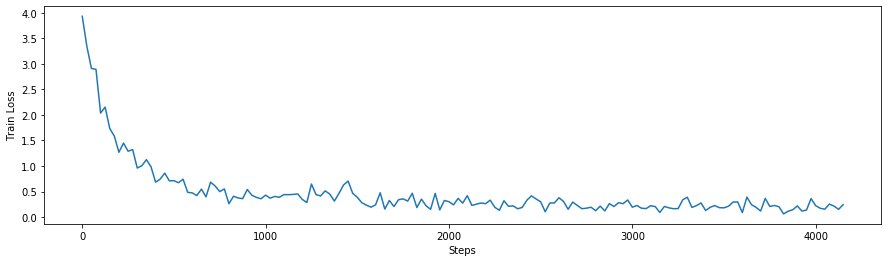

In [186]:
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = 20, 5

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()

The blue curve in the graph below shows that the default training configuration ran the training for too long. Instead of training for 4000 steps, early-stopping should have been applied after 1000 steps.

<br/>

### Enable auto-termination when rule triggered <a name="termination"></a>

Debugger emits metrics to CloudWatch, so users can setup a CloudWatch alarm and [Lambda function](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-cloudwatch-lambda.html) that terminates a training job if a rule triggers. 



<img src="images/action_on_rule.png" alt="drawing" width="600"/>

With Debugger we can enable auto-termination which stops the training once a rule triggers. In this example doing so reduces compute time by more than half (orange curve). We re-run the training, create another trial object and compare loss curves from two different trials. Check out this [tutorial](https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-debugger/tensorflow_action_on_rule/tf-mnist-stop-training-job.ipynb) or the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-cloudwatch-lambda.html) to learn more how to setup CloudWatch alarm and Lambda function 

![](images/loss.png)

<br/>

### Investigate why 'Class imbalance' rule triggered  <a name="classimbalance"></a>

Real world data sets are often imbalanced and noisy. If the model training does not account for these factors, it will produce a model that has low or no predictive power for the classes with few samples. There are different ways this problem can   be addressed: for instance during data-loading, more samples can be drawn from the under-represented classes or  one can adjust the loss function to assign a higher penalty to incorrect predictions using class weights.

To investigate the class imbalance issue, we retrieve the inputs of the loss function (previously we retrieved the outputs).  The loss layer takes  the model predictions and the ground-truth labels as inputs. We use latter one (`CrossEntropyLoss_input_1`) to count the number of samples the model has seen during training. 


In [6]:
from collections import Counter
from smdebug import modes

labels = []
for step in trial.steps(mode=modes.TRAIN):
    labels.extend(trial.tensor("CrossEntropyLoss_input_1").value(step, mode=modes.TRAIN))

label_counts = Counter(labels)

As shown in the figure below there is a high imbalance and several classes are seen 10 times more often.

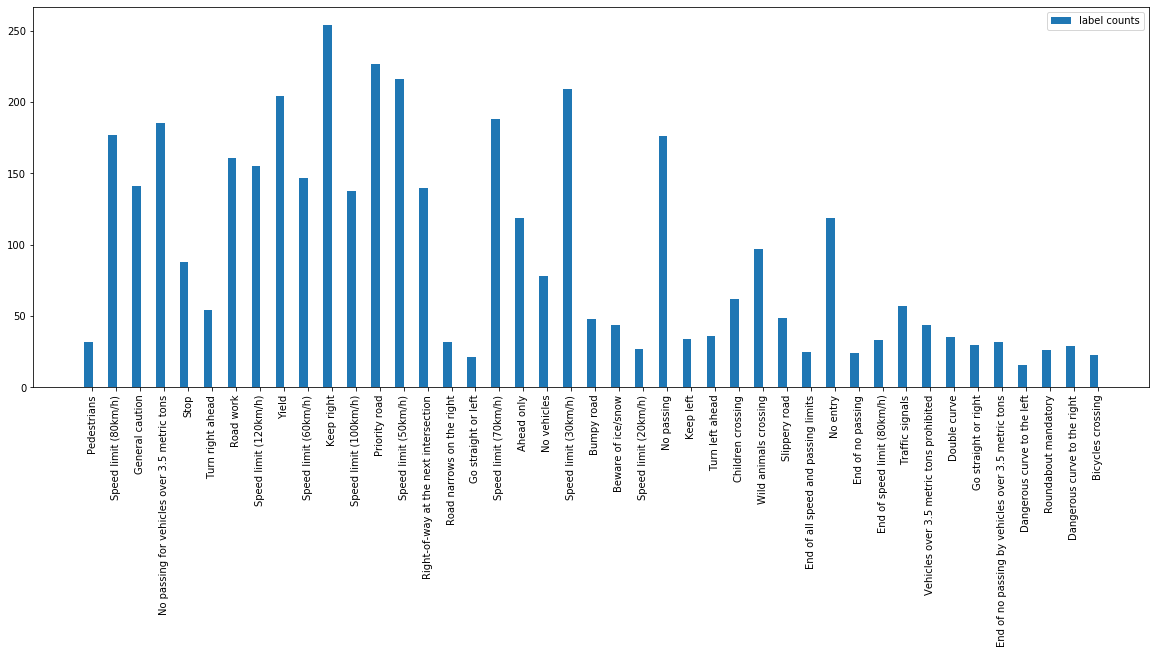

In [200]:
import numpy as np

label_names = []
for i in label_counts:
    label_names.append(signnames[i])
    
plt.bar(np.arange(0,len(label_counts))*3,  label_counts.values(), width=1.1, label="label counts")
plt.xticks(np.arange(0,len(label_counts))*3+0.5, label_names)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

To fix the class imbalance issue, we change the default configuration of the dataloaders to take the class weights into account and to draw more samples from classes with fewer samples. Therefore we define a WeightedRandomSampler 

```python
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     

train_dataloader = torch.utils.data.DataLoader(dataset, 
                                                batch_size=64,
                                                sampler=sampler)
```

During training, the dataloader will now draw more samples from classes with lower counts. Class imbalance may lead to the problem where the model performs well on classes with a lot of samples but poorly on classes with fewer counts. Since we trained the model without `WeightedRandomSampler`, let’s see which classes had particularly low accuracy by looking at confusion matrix.

<br/>

### Plot confusion matrix <a name="confusion"></a>

To evaluate the performance of our model, we retrieve labels and predictions  and create the confusion matrix:

In [224]:
import numpy as np

predictions = []
labels = []
for step in trial.steps(mode=modes.EVAL):
    predictions.extend(np.argmax(trial.tensor("CrossEntropyLoss_input_0").value(step, mode=modes.EVAL), axis=1))
    labels.extend(trial.tensor("CrossEntropyLoss_input_1").value(step, mode=modes.EVAL))

Each row in the matrix corresponds to the actual class while the column indicates the predicted classes. For example, the first row shows class 0 and how often it was predicted as class 0, class 1, class 2 etc. Ideally we want high counts on the diagonal, since these are correctly predicted classes. Elements not on the diagonal are incorrect predictions. The confusion matrix helps us determine if there are particular classes in our dataset that get confused more often with each other. This can happen for instance because samples from two different classes may be very similar. Debugger also provides a [confusion](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#confusion) builtin rule that computes the confusion matrix as the training is in progress and triggers if ratio of data on-diagonal values and off-diagonal values exceeds a pre-defined threshold.
The image below shows that in most cases our model is predicting the correct classes, but there are a few outliers. You can use Debugger to look more closely into those outliers.


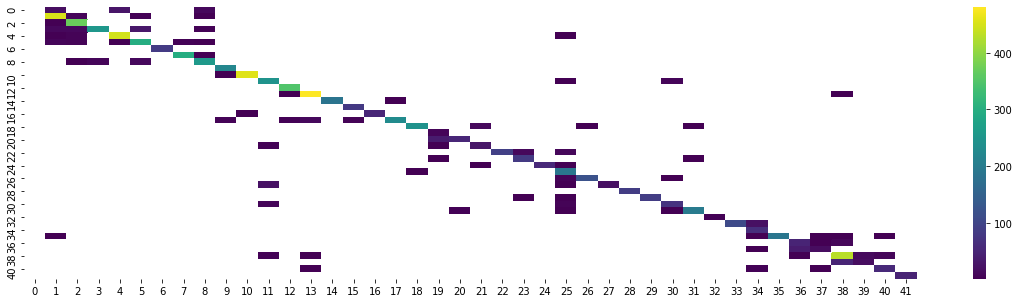

In [248]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots()
cm = confusion_matrix(labels,predictions)
cmap = plt.cm.viridis
cmap.set_under(color='white') 
sns.heatmap(cm, ax=ax, cbar=True, cmap=cmap, vmin=1)

<br/>

### Inspect incorrect predictions <a name="incorrect"></a>

To find out what is causing those outliers in the confusion matrix, we investigate the examples upon which the model made false predictions. To do this analysis we take now both inputs into the loss layer into account: `CrossEntropyLoss_input_0`  presents the model predictions and `CrossEntropyLoss_input_1` are the labels. At the same time we retrieve the model inputs ResNet_input_0 which presents the input images. We perform the analysis on data recorded during the validation phase so we specify `mode=modes.EVAL`.
We iterate over the predictions and model inputs saved by Debugger and simply select those where the label and prediction do not match. Then we plot the predictions and corresponding images.


Predicted: 'Turn left ahead' Groundtruth: 'Turn right ahead' 


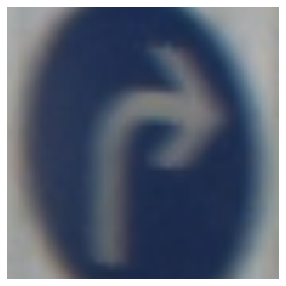

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 'Keep right' Groundtruth: 'Keep left' 


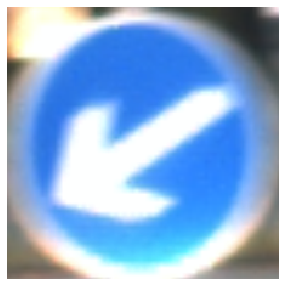

Predicted: 'Keep right' Groundtruth: 'Keep left' 


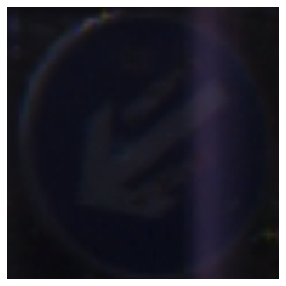

Predicted: 'Keep right' Groundtruth: 'Keep left' 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


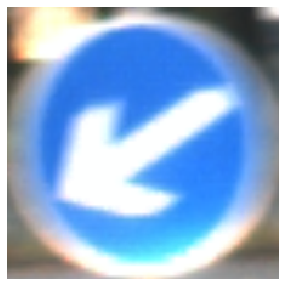

Predicted: 'Keep right' Groundtruth: 'Keep left' 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


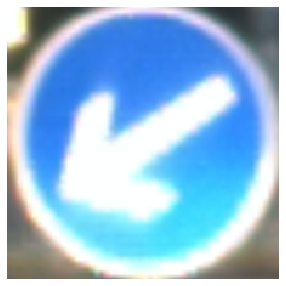

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: 'Keep right' Groundtruth: 'Keep left' 


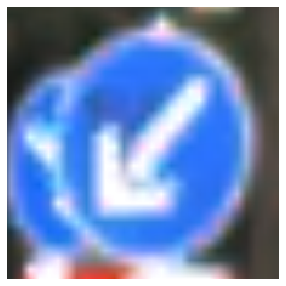

In [31]:

for step in trial.steps(mode=modes.EVAL)[-5:]:
    counter = 0
    predictions = np.argmax(trial.tensor('CrossEntropyLoss_input_0').value(step, mode=modes.EVAL),axis=1)
    labels = trial.tensor('CrossEntropyLoss_input_1').value(step, mode=modes.EVAL)
    images = trial.tensor('ResNet_input_0').value(step, mode=modes.EVAL)
    
    for prediction, label, image in zip(predictions, labels, images):
        if prediction != label:
            print(f"Predicted: '{signnames[prediction]}' Groundtruth: '{signnames[label]}' ")
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]

            image = image.transpose(1, 2, 0)
            image = (image * std) + mean
            plt.imshow(image)
            plt.axis('off')
            plt.show()


The figure below shows the result of the code segment. The analysis reveals that the model is often confused about traffic signs that involve a direction. Clearly this is a severe model bug despite the model achieving a decent test accuracy of 93.6%. The root cause of this is the data augmentation pipeline that performs a random horizontal flip on the training data. Check out the [training script](entry_point/train.py) for more details.

```python
    train_transform =  transforms.Compose([
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
```

<br/>

### Custom rule   <a name="custom"></a>

With Debugger we can very easily write a custom rule that checks how often the model was confused about directions. As an example we take the image "Turn right ahead" (class 34) and count how often it was mistaken as "Turn left ahead" (class 33) or vice versa. We just need to implement the function `invoke_at_step` that Debugger will call every-time data for a new step is available. Like before we access the inputs into the loss layer and check if image class 33 or 34 is present and count how often it was mistaken for the other. If this happens more than 5 times the rule triggers.

In [32]:
from smdebug.rules.rule import Rule
import numpy as np

class MyCustomRule(Rule):
    def __init__(self, base_trial):
        super().__init__(base_trial)
        self.trial = base_trial
        self.counter = 0
        
        
    def invoke_at_step(self, step):
        
        #get predictions and labels
        predictions = np.argmax(self.trial.tensor('CrossEntropyLoss_input_0').value(step),axis=1)
        labels = self.trial.tensor('CrossEntropyLoss_input_1').value(step)

        #iterate over predictions and labels
        for prediction, label in zip(predictions, labels):
   
            #class is "Turn right ahead" and has been mistaken as "Turn left ahead" or vice versa:
            if prediction == 34 and label == 33 or prediction == 33 and label == 34:

                self.counter += 1
                
                #return True if the model has done this mistake more than 5 times.
                if self.counter > 5:
                    self.logger.info(f'Found {self.counter} where class 19 was mistaken as class 20 and vice versa')
                    return True
                
        return False


We can easily test and run the custom rule locally by first creating the trial object and then invoke the rule on the data.

In [33]:
from smdebug.trials import create_trial
from smdebug.rules import invoke_rule
from smdebug.exceptions import *

rule = MyCustomRule(trial)
try:
    invoke_rule(rule, raise_eval_cond=True)
except RuleEvaluationConditionMet as e:
    print(e)

[2020-10-27 02:10:03.517 ip-172-16-17-92:16227 INFO action.py:20] No action specified. Action str is 
[2020-10-27 02:10:03.522 ip-172-16-17-92:16227 INFO rule_invoker.py:15] Started execution of rule MyCustomRule at step 0
[2020-10-27 02:10:12.035 ip-172-16-17-92:16227 INFO <ipython-input-32-0b4c468f13d2>:27] Found 6 where class 19 was mistaken as class 20 and vice versa
[2020-10-27 02:10:12.036 ip-172-16-17-92:16227 INFO action.py:81] Invoking actions
Evaluation of the rule MyCustomRule at step 1494 resulted in the condition being met


Once the rule has been tested locally, we can run it as part of our SageMaker training job. First we need to save the rule in a separate file and then define the following configuration where we indicate on which instance type the rule should run and we also specify the URI for the rule container. You can find the image URI for your region in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-docker-images-rules.html#debuger-custom-rule-registry-ids).

In [34]:
from sagemaker.debugger import Rule, CollectionConfig

custom_rule = Rule.custom(
    name='MyCustomRule',
    image_uri='759209512951.dkr.ecr.us-west-2.amazonaws.com/sagemaker-debugger-rule-evaluator:latest', 
    instance_type='ml.c4.xlarge',
    volume_size_in_gb=400,     
    source='my_custom_rule.py', 
    rule_to_invoke='MyCustomRule',     
)  

Once the configuration is defined we can just add the custom_rule to the list of rules in the Estimator object.


## Fix and re-run the training  <a name="fix"></a>

Now that Debugger has helped us to identify some critical issues in our model, we apply the fixes and re-run the training. As mentioned before weighted re-sampling allows us to fix the class imbalance problem. We also change the data augmentation pipeline and remove the horizontal flip. We reduce the number of epochs from 10 to 3, since we have seen that the loss does not decrease after roughly 1000 iterations. 


In [43]:
import sagemaker 
from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

pytorch_estimator2 = PyTorch(entry_point='train_fixed.py',
                            source_dir='entry_point',
                            role=role,
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            framework_version='1.6.0',
                            py_version='py3',
                            hyperparameters = {'epochs': 3, 
                                               'learning_rate': 0.001},
                            debugger_hook_config=debugger_hook_config,
                            rules=[class_imbalance_rule, dead_relu_rule, loss_not_decreasing_rule, custom_rule]
                           )

In [46]:
pytorch_estimator2.fit(inputs={'train': 's3://{}/gtsrb_train'.format(bucket), 
                              'test': 's3://{}/gtsrb_test'.format(bucket)}, 
                      wait=False)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter 'session' will be renamed to 'sagemaker_session' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [ ]:
trial2 = create_trial(pytorch_estimator2.latest_job_debugger_artifacts_path())

With Debugger we can now compare data from different training jobs and see if the issues persist or not. We just need to create a new trial object, read data from both trials and compare their tensors. The following image shows the label counts for the original training job and the one where we applied weighted re-sampling (orange). We see that there is no longer a class imbalance issue and the model sees roughly the same amount of instances per class.


In [ ]:
labels = []
for step in trial2.steps(mode=modes.TRAIN):
    labels.extend(trial2.tensor("CrossEntropyLoss_input_1").value(step, mode=modes.TRAIN))

label_counts2 = Counter(labels)

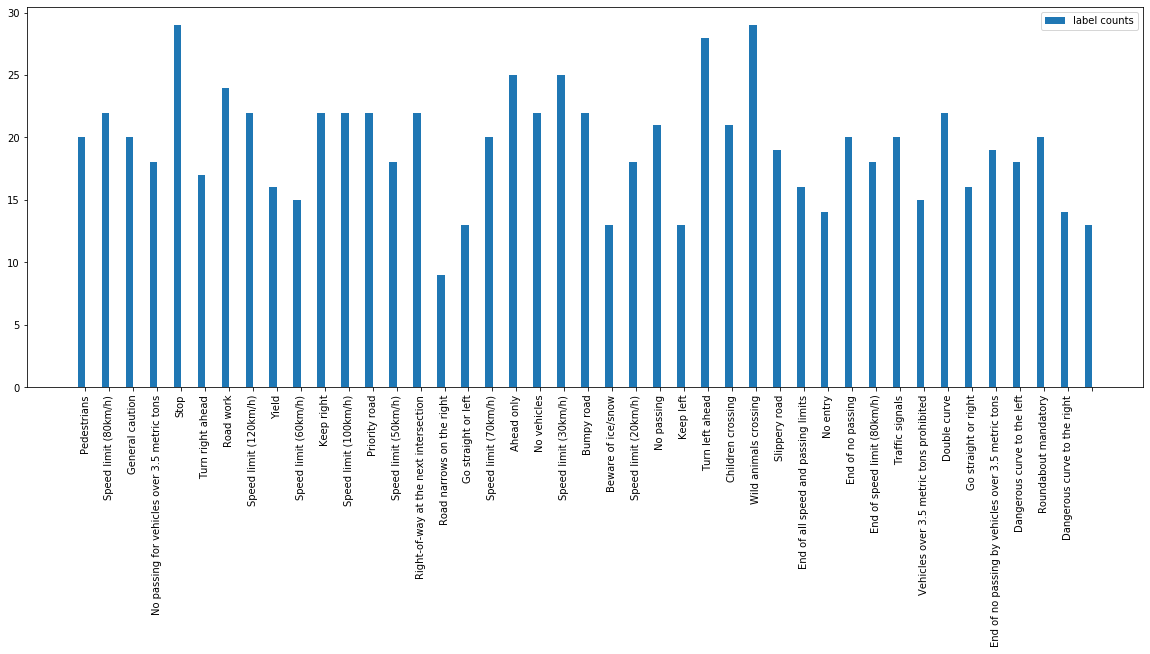

In [121]:
plt.bar(np.arange(0,len(label_counts2))*3.5,  label_counts2.values(), width=1.1, label="label counts")
plt.xticks(np.arange(0,len(label_counts2))*3.5+0.5, label_names)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

We run the training with the same builtin rules as before and further we add our own custom rule. We monitor the status of the rules and can now see that none of them triggers any longer. Not only did we fix some critical issues in our model, but also reduced the training time by a factor 2.

In [48]:
pytorch_estimator2.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'ClassImbalance',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:283429445338:processing-job/pytorch-training-2020-10-2-classimbalance-8416212c',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 10, 27, 2, 27, 4, 531000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'DeadRelu',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:283429445338:processing-job/pytorch-training-2020-10-2-deadrelu-2cef29c1',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 10, 27, 2, 27, 4, 531000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:283429445338:processing-job/pytorch-training-2020-10-2-lossnotdecreasing-25a6e6f9',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2020, 10, 27, 2, 27, 4, 531000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'MyCustomRule',
  'RuleEvaluati

![](images/studio2.png)